In [1]:
# !pip install wheel==0.38.4
# !pip install setuptools==65
# !pip install gym==0.21
# !pip install torchrl
# pip install stable-baselines3[extra]
# !pip install torchvision
# !pip install gym==0.21

In [2]:
from IPython.display import clear_output
from PIL import Image
import matplotlib.pyplot as plt
import gym
import torchvision
import torch
import numpy as np
import torchrl

In [3]:
gym.version.VERSION


'0.21.0'

In [4]:
_env = gym.make("ALE/Assault-v5").env

n_actions = _env.action_space.n # see more info in actions.txt

print("n_actions=", n_actions)

from torchrl.envs import *
from torchrl.envs.libs.gym import *

env = TransformedEnv(
    GymEnv("ALE/Assault-v5", from_pixels=True),
    Compose(
        ToTensorImage(in_keys=["pixels"], out_keys=["pixels_trsf"]),
        Resize(in_keys=["pixels_trsf"], w=64, h=64),
        GrayScale(in_keys=["pixels_trsf"]),
        FrameSkipTransform(4), 
    ),
) 

state = env.reset()

print(state)

n_actions= 7


C:\Users\vinik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_wrapper_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(
C:\Users\vinik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.reward_space to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.reward_space` for environment variables or `env.get_wrapper_attr('reward_space')` that will search the reminding wrappers.
  logger.warn(


TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        pixels: Tensor(shape=torch.Size([210, 160, 3]), device=cpu, dtype=torch.uint8, is_shared=False),
        pixels_trsf: Tensor(shape=torch.Size([1, 64, 64]), device=cpu, dtype=torch.float32, is_shared=False),
        terminated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        truncated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)


torch.Size([1, 64, 64])


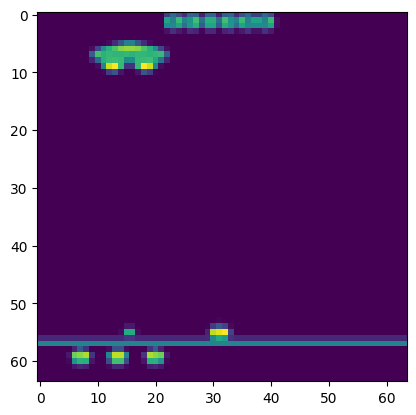

In [5]:
state = env.reset()

print(state['pixels_trsf'].shape)

plt.imshow(state['pixels_trsf'].permute(1, 2, 0))

In [6]:
import torch

import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self, num_channels, height, width, n_actions):
        super(NeuralNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=1, kernel_size=(8, 8), stride=(1, 1))
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(8, 8), stride=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(4, 4), stride=(1, 1))
        self.pool = nn.MaxPool2d((2, 2))

        self.fc_size = self.compute_fc_size(num_channels, height, width)

        self.fc1 = nn.Linear(self.fc_size, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 16)
        self.fc4 = nn.Linear(16, n_actions)
        
    def compute_fc_size(self, num_channels, height, width):
        # Применение сверточных и пулинг слоев для вычисления размера входа
        x = torch.rand(1, num_channels, height, width)
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.pool(self.conv3(x))

        # Вычисление размера входа для полносвязанного слоя
        fc_size = x.view(1, -1).size(1)
        return fc_size
    
    
    def forward(self, x):

        x = self.pool(self.conv1(x)) # F.RELU???
        x = self.pool(self.conv2(x))
        x = self.pool(self.conv3(x))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x

In [7]:
def build_model(num_channels, height, width, n_actions):
      model = NeuralNetwork(num_channels=num_channels, height=height, width=width, n_actions=n_actions)
      # self.buffer = PrioritizedReplayBuffer(50000)
      return model

model = build_model(1, 64, 64, n_actions)
opt = torch.optim.Adam(model.parameters(), lr=5e-3)

In [8]:
def get_action(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.choice(np.arange(0, n_actions))

    q_values = model(state).detach().numpy()

    return int(np.argmax(q_values))

In [9]:
def compute_td_loss(states, _actions, rewards, next_states, is_done, gamma=0.99, check_shapes=False):
    """ Compute td loss using torch operations only. Use the formula above. """
    states = torch.tensor(states, dtype=torch.float32)    # shape: [batch_size, state_size]

    # print(next_states)

    actions = []
    for i in range(_actions.shape[0]):
        actions.append(_actions[i].argmax())

    actions = torch.tensor(actions, dtype=torch.long)    # shape: [batch_size]
    # print(actions)
    rewards = torch.tensor(rewards, dtype=torch.float32)  # shape: [batch_size]
    next_states = torch.tensor(next_states, dtype=torch.float32) # shape: [batch_size, state_size]
    is_done = torch.tensor(is_done, dtype=torch.uint8)  # shape: [batch_size]

    # get q-values for all actions in current states
    predicted_qvalues = model(states)

    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[
      range(states.shape[0]), actions
    ]

    # compute q-values for all actions in next states
    predicted_next_qvalues = model(next_states).detach()

    # compute V*(next_states) using predicted next q-values
    # print(predicted_next_qvalues)
    next_state_values = torch.max(predicted_next_qvalues, 1)[0]
    # print(next_state_values)

    assert next_state_values.dtype == torch.float32

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    target_qvalues_for_actions = rewards + gamma * next_state_values

    # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    target_qvalues_for_actions = torch.where(
        is_done, rewards, target_qvalues_for_actions)
    
    # print(predicted_qvalues_for_actions)

    # print((predicted_qvalues_for_actions -
                    #   target_qvalues_for_actions.detach()) ** 2)

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions -
                      target_qvalues_for_actions.detach()) ** 2)
    
    if check_shapes:
        assert predicted_next_qvalues.data.dim(
        ) == 2, "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim(
        ) == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim(
        ) == 1, "there's something wrong with target q-values, they must be a vector"

    return loss

In [10]:
def step(states, actions, rewards, next_states, dones):
    # print("lol")
    # print(states, actions, rewards, next_states, dones)
    opt.zero_grad()
    L = compute_td_loss(states, actions, rewards, next_states, dones)
    x = L.detach()
    L.backward()
    opt.step() 

    return x

In [11]:
n_actions = env.action_space.n

print(n_actions)
from torchrl.data import *
from torchrl.data.replay_buffers.samplers import PrioritizedSampler

size = 10000

from tensordict import TensorDict
rb = TensorDictReplayBuffer(storage=ListStorage(size), sampler=PrioritizedSampler(size, alpha=0.8, beta=1.1), batch_size=1)
L = []

7


In [12]:
def generate_session(t_max=1000, epsilon=0, train=False):
    """play env with approximate q-learning agent and train it at the same time"""
    env = TransformedEnv(
        GymEnv("ALE/Assault-v5", from_pixels=True),
        Compose(
                ToTensorImage(in_keys=["pixels"], out_keys=["pixels_trsf"]),
                Resize(in_keys=["pixels_trsf"], w=64, h=64),
                GrayScale(in_keys=["pixels_trsf"]),
                FrameSkipTransform(4), 
        ),
    ) 
    total_reward = 0
    state = env.reset()

    # передаем pixels

    for t in range(t_max):
        # state['index'] = torch.zeros(1) + cnt
        # print(state)
        # env.render()
        action = get_action(state['pixels_trsf'])
        # print(action)
        
#         Action = torch.zeros(n_actions)
#         Action[action] = 1
        
        state['action'] = torch.zeros(n_actions)
        state['action'][action] = 1
        
#         td = TensorDict({'action': Action}, batch_size=torch.Size([]))
        
        next_state = env.step(state)['next']

        state['next'] = next_state 
        rb.add(state)       
#         print(next_state)
        
#         next_state = result['pixels_trsf']
        reward = next_state['reward'][0]
        done = next_state['done'][0]
        truncated = next_state['truncated'][0]

        
#         print(next_state, reward, done, truncated)

        done = done or truncated

        total_reward += reward
        state = next_state
        if done:
            break
            
        # plt.imshow(state['pixels_trsf'].permute(1, 2, 0))
        # plt.show()
        # clear_output(True)

    return total_reward

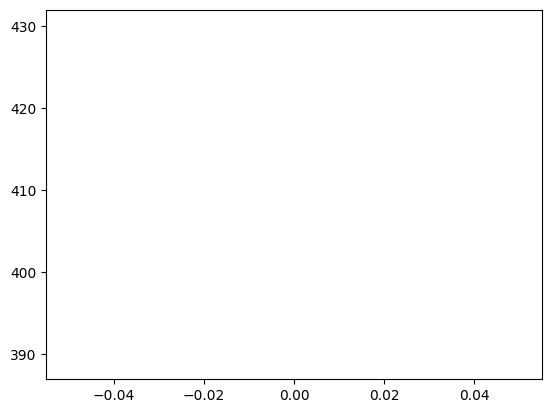

1


 25%|██▌       | 5/20 [00:22<01:06,  4.41s/it]

In [13]:
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings('ignore')
import tqdm
L = []
R = []

for _ in range(20):
    print(_)
    r = []
    for __ in tqdm.tqdm(range(20)):
        r.append(generate_session(epsilon=0.1))
    
    R.append(np.mean(r))

    clear_output(True)

    x, info = rb.sample(1000, return_info=True)
    # print(info)
    # print(x)

    x['next']['done'] = x['next']['done'] + x['next']['truncated']
    
    wow = step(x['pixels_trsf'], x['action'], x['next']['reward'], x['next']['pixels_trsf'], x['next']['done']).detach()

    # print(wow)
    wow = torch.ones(len(info['index'])) * wow

    rb.update_priority(index=info['index'], priority=wow + 1e-6)

    L.append(wow.numpy().mean())
    # print(L)
    # print(x)

    z = range(len(R))
    z = list(z)

    plt.plot(z, R)
    plt.show()
z = range(len(L))
z = list(z)

plt.plot(z, L)
plt.show()
# Parallel(n_jobs=-2)(delayed(generate_session)() for _ in range(15))